# Simple predictions of successful funding - logistic regression

### _Lukas Vlcek_

## 1. Introduction

Logistic regression is used to classify expected success or failure of Kickstarter projects.
The features include project category, country of origin, goal amount, project name, and its description.

## 2. Data setup

Notebook configuration

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Create a dataframe from a pre-processed CSV file and filter out uninformative features

In [2]:
target_path = '../data/processed'
report_path = '../reports'
filename = 'kick_id.csv'
datecols = ['created_at', 'deadline', 'state_changed_at', 'launched_at']
fdatpars = lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')
df = pd.read_csv(os.path.join(target_path, filename), index_col='id', parse_dates=datecols, date_parser=fdatpars)

Filter out unneeded data and add some indicator features

In [3]:
df = df.drop(['disable_communication'], axis='columns')
df = df.loc[(df['state'] != 'live') & (df['state'] != 'suspended')]
cat_type = [x.split('/')[0] for x in df['category'].values]
df['cat_type'] = np.array(cat_type)
#df['dummy'] = 1
df['period'] = (df['launched_at'] >= '2014-06-01') & (df['launched_at'] < '2018-01-01')
df['succeeded'] = np.int_(df['state'] == 'successful')
df['staff_pick'] = np.int_(df['staff_pick'])
#df.sort_values('launched_at').loc[df.period]['launched_at'].shape

In [4]:
# counting words in project names and blurbs
df.loc[df['blurb'].isnull(), 'blurb'] = ''
df.loc[df['name'].isnull(), 'name'] = ''
df['blurb_wlen'] = df['blurb'].str.split().apply(len)
df['name_wlen'] = df['name'].str.split().apply(len)

In [5]:
# make new dataframes with new and old data
dfn = df.loc[df.period].copy()
dfo = df.loc[~df.period].copy()
dfn.shape, dfo.shape

((149007, 22), (89449, 22))

In [6]:
# take logarithm of goals
dfn['goal_log'] = np.log10(dfn['goal'].values)

In [7]:
# drop unwanted columns
dfm = dfn.drop(['usd_pledged','goal','state','slug','currency','deadline','state_changed_at','created_at','backers_count','spotlight','period'], axis=1).copy()
# get dummies
dfd = pd.get_dummies(dfm, columns=['country','cat_type'])

In [8]:
dfm.head()

,name,pledged,country,launched_at,staff_pick,blurb,category,cat_type,succeeded,blurb_wlen,name_wlen,goal_log
id,,,,,,,,,,,,
18520,Grandma's are Life,62.0,US,2016-10-19 09:32:40,0,Raising money to help my grandmother recover f...,music/world music,music,0,24,3,4.176091
21109,Meta,173.0,GB,2015-04-07 18:37:44,0,My work is performance based but I branch out ...,art/performance art,art,1,24,1,2.176091
24380,Puss N' Books: A relaxing cat cafe and bookstore.,776.0,US,2015-10-27 11:25:33,0,A sanctuary for humans and felines alike! Come...,food/spaces,food,0,24,9,4.301030
33867,TASTE MAKERS BY TRISH P,2798.0,CA,2015-06-15 14:28:11,1,Taste Makers is a socially conscious brand tha...,fashion/ready-to-wear,fashion,0,23,5,4.255273
39036,The Meat Candy Experience,3239.0,US,2016-05-16 18:34:18,0,"The BEST beef sticks, beef jerky and signature...",food/small batch,food,1,13,4,3.397940


## 3. Modeling

In [9]:
# ML imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline, FeatureUnion

Select predictor and target columns for model fitting

In [10]:
predictors_nt = []
predictors_nt.extend([c for c in dfd.columns if c[0:5] == 'cat_t' ])
predictors_nt.extend([c for c in dfd.columns if c[0:5] == 'count' ])

predictors_nt.extend(['goal_log', 'name_wlen'])
#predictors.extend(['goal_log','name_wlen', 'staff_pick'])

predictors_text = []
predictors_text.extend(['name', 'blurb'])

predictors = predictors_nt + predictors_text

target = ['succeeded']
#target = ['staff_pick']

Train-test split for pandas dataframe

In [11]:
df_train=dfd.sample(frac=0.8,random_state=200)
df_test=dfd.drop(df_train.index)

In [12]:
# Training dataset
Xtrain = df_train[predictors]
ytrain = df_train[target].values.astype(np.int).flatten() 

# Testing dataset
Xtest = df_test[predictors]
ytest = df_test[target].values.astype(np.int).flatten() 

### 3.1 Create a pipeline

1. Textual features (name, blurb) will be separated for their individual treatment
2. Textual features will be individually vectorized
3. $\chi^2$ feature selection will be performed on the vectorized features.
4. The selected textual features will be combined with other features
5. Logistic regression will be applied. (LASSO regularization will further reduce the number of relevant features).



#### 3.1.1 Define classes needed to separate and join selected features from pandas dataframes

In [13]:
# Define a selector class to be used in the main pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select a column from pandas dataframe.
    Transfrom returns pandas Series """
    
    def __init__(self, column=''):
        self.column = column

    def fit(self, dataframe, y=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.column]

In [14]:
class FeaturesSelector(BaseEstimator, TransformerMixin):
    """Select columns from pandas dataframe.
    Transform returns numpy array with one or more features"""
    
    def __init__(self, columns=[]):
        self.columns = columns

    def fit(self, dataframe, y=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.columns].values

#### 3.1.2 Define pipeline structure

In [15]:
# Define the main pipeline (contains sub-pipelenes for text processing and feature selection)
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('name', Pipeline([
                ('selector', ColumnSelector('name')),
                ('vectorizer', CountVectorizer()),
                ('reduce_dim', SelectKBest(chi2, k=100))
            ])),
            ('blurb', Pipeline([
                ('selector', ColumnSelector('blurb')),
                ('vectorizer', CountVectorizer()),
                ('reduce_dim', SelectKBest(chi2, k=1000))
            ])),
            ('rest', Pipeline([
                ('selector', FeaturesSelector(predictors_nt)),
            ]))
        ])),
    ('logreg', LogisticRegression(penalty='l2', C=0.1))
])

### 3.2 Fit pipeline and print parameter information

In [16]:
pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('name', Pipeline(steps=[('selector', ColumnSelector(column='name')), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [17]:
logreg = pipeline.named_steps['logreg']
print('Number of features:', len(logreg.coef_[0]))
print('Number of non-zero features:', np.sum(logreg.coef_ != 0.0))
print('Maximal regression coefficient:', logreg.coef_.max())

indices = np.nonzero(pipeline.named_steps['union'].transformer_list[0][1].named_steps['reduce_dim'].get_support())
voca = pipeline.named_steps['union'].transformer_list[0][1].named_steps['vectorizer'].vocabulary_
print('\nWords from project names selected by chi2 feature selection as most informative of success/failure.\n')
print([key for key, value in voca.items() if value in indices[0]])

Number of features: 1139
Number of non-zero features: 1139
Maximal regression coefficient: 1.50586055239

Words from project names selected by chi2 feature selection as most informative of success/failure.

['terrain', 'the', 'by', 'album', 'playing', 'cards', 'presents', 'board', 'game', 'mobile', 'comic', 'book', 'vol', 'canceled', 'app', 'new', 'of', 'film', 'short', 'com', 'dance', 'enamel', 'pins', 'restaurant', 'business', 'my', 'most', 'burning', '2014', 'novel', 'debut', 'ep', 'watch', 'youtube', 'brand', 'steampunk', 'about', 'minimalist', '2016', 'record', 'roleplaying', 'social', 'apparel', 'volume', 'watches', 'food', 'miniatures', 'bike', 'bag', 'edinburgh', 'edition', 'tarot', 'full', 'length', 'fantasy', 'rpg', 'issue', 'pin', '2017', 'network', 'fashion', 'tabletop', 'coloring', 'dice', 'clothing', 'sci', 'fi', 'season', 'nudes', 'documentary', 'dungeon', 'wallet', 'truck', 'set', 'pens', 'backpack', 'card', '5e', 'online', 'website', 'titanium', 'anthology', 'media', '

The most important words are highly indicative of the category, so conditioning on category (have predictors for each category), may select a smaller number of words adding truly new information.

### 3.3 Predict labels and probabilities

In [18]:
y_pred = pipeline.predict(Xtest)
y_pred_prob = pipeline.predict_proba(Xtest)

### 3.4 Prediction statistics

In [19]:
print('Accuracy on the training data:', pipeline.score(Xtrain, ytrain))
print('Accuracy on the testing data:', pipeline.score(Xtest, ytest))

Accuracy on the training data: 0.754181836485
Accuracy on the testing data: 0.746485017281


AUC 0.817426000062


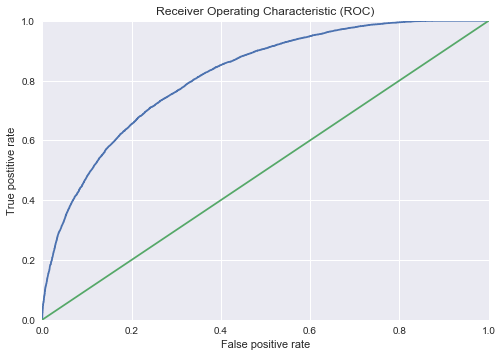

In [20]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.axis([0,1,0,1])
plt.xlabel('False positive rate')
plt.ylabel('True postitive rate')
plt.title("Receiver Operating Characteristic (ROC)")
print('AUC', roc_auc_score(ytest, y_pred_prob[:,1]))

In [21]:
print(classification_report(ytest, y_pred))

             precision    recall  f1-score   support

          0       0.77      0.85      0.80     18386
          1       0.70      0.59      0.64     11415

avg / total       0.74      0.75      0.74     29801



### Predicting staff picks

Staff picks can be considered as optimizing precision. The data shows precision of 0.86, with recall of 0.21.

Setting the threshold to 10% selected projects, we can predict precision and recall of staff picks from our model.

In [22]:
# Find threshold for 10% selection rate
#thresh = np.linspace(0.0, 1.0, 101)
#for t in thresh:
#    print(t, np.sum(y_pred_prob[:,1] > t)/y_pred_prob.shape[0])

y_predx = np.int_(y_pred_prob[:,1] > 0.77)
print('Fraction of picked projects at threshold 0.77:', np.sum(y_predx)/y_predx.shape[0])

Fraction of picked projects at threshold 0.77: 0.0962719371833


In [23]:
print(classification_report(ytest, y_predx))

             precision    recall  f1-score   support

          0       0.67      0.98      0.79     18386
          1       0.85      0.21      0.34     11415

avg / total       0.74      0.68      0.62     29801



Our model picks based match almost exactly the precision (0.86) and recall (0.22) of real staff picks, which are not available to proposers.